# University of Applied Sciences Munich
## Kalman Filter Tutorial

---
(c) Lukas Köstler (lkskstlr@gmail.com)

In [1]:
import ipywidgets as widgets
from ipywidgets import interact_manual
from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 3)

import numpy as np
%matplotlib notebook

In [22]:
def normal_pdf(x, mu=0.0, sigma=1.0):
    return 1.0 / np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5/sigma**2 * (x-mu)**2)

#### Possible sources:
+ (One of the most prominent books on robotics) https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf
+ (Many nice pictures) http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
+ (Stanford lecture slides) https://stanford.edu/class/ee363/lectures/kf.pdf


## Kalman Filter
---
* We will develop everything with an example in mind:

 One throws an object into the air and for some timepoints $t_0, t_2, \dots, t_N$ measures the position $x$ and the velocity $v$ of the object. The measurements have some error. We want to find the best estimate of the positions $x_0, x_1, \dots, x_N$ for said timepoints.
 
* Under certain conditions the Kalman Filter (~ 1960) is the optimal tool for this task

### State & Control
---
* The state at time $t_n$ is denoted by $x_n$

 Example: Height above ground in meters

* The control at time $t_n$ is denoted $u_n$

 Example: Vertical velocity in meters/second

### Transition Model
---
* The *simplified* transition model gives the new state
$$ x_{n+1} = A x_n + B u_n $$

 Example (simple mechanics):
 $$x_{n+1} = \underbrace{1}_{A} \, x_n + \underbrace{\Delta t}_{B} \,u_n$$

### Transition Model with Noise
---
* The transition model might not be perfect. Thus we add a random term (gaussian)
$$ x_{n+1} = A x_n + B u_n + w_n, \,\,\, w_n \sim N(0, \sigma_w)$$

 Example: Because $\mu = 0$ we assume that we have no systematic error in the transition model. $\sigma_w$ is the expected error per transition, e.g. 0.1 meters due to friction etc..

### Observation Model
---
* At each timepoint $t_n$ we observe/measure the state:
$$ z_{n} = C x_n$$

 Example (we measure the height in meters directly):
 $$z_{n} = \underbrace{1}_{C} \, x_n$$
 
 If we would measure the height in centimeters one would get:
 $$z_{n} = \underbrace{100}_{C} \, x_n $$

### Observation Model with Noise
---
* The measurement (either the device or our model) might not be perfect. Thus we add a random term (gaussian)
$$ z_{n} = C x_n + v_n,  \,\,\, v_n \sim N(0, \sigma_v)$$

 Example: Because $\mu = 0$ we assume that we have no systematic error in the measurement model. $\sigma_v$ is the expected error per measurement, e.g. 0.5 meters as given in the sensors data sheet.

## The Filter
---
* **Predict**

 Take the old estimate $\hat{x}_n$ and the transition model to get $\hat{x}_{n+1\vert n}$ which is the new "guess" without using the measurement $y_{n+1}$.
 
 
* **Update/Correct**

 Take the new "guess"/prediction $\hat{x}_{n+1\vert n}$ and the measurement $y_{n+1}$ to get the final estimate $\hat{x}_{n+1}$.

### Predict
---
* Reminder: $ x_{n+1} = a x_n + b u_n + w_n, \,\,\, w_n \sim N(0, \sigma_w), \, a, b \in \mathcal{R}$
* Which gives:

\begin{align}
\text{mean:}& &E[\hat{x}_{n+1\vert n}] &= a E[\hat{x}_n] + b u_n + 0 \\
\text{variance:}& &Var(\hat{x}_{n+1 \vert n}) &= a^2 Var(\hat{x}_n) + 0 + \sigma_w^2 \\[2ex]
&& \mu_{n+1 \vert n} &= a \mu_{n} + b u_n \\
&& \sigma_{n+1 \vert n}^2 &= a^2 \sigma_{n}^2 + \sigma_w^2
\end{align}



In [20]:
%%capture
mu_n = 1.0
sigma_n = 0.5

# parameters to be animated
a = 1.0
bu_n = 0.1
sigma_w = 0.4


xx = np.linspace(-5,5,1000)
yyxn = normal_pdf(xx, mu_n, sigma_n)
yyaxn = normal_pdf(xx, a*mu_n, np.abs(a)*sigma_n)
yybun = normal_pdf(xx, a*mu_n + bu_n, np.abs(a)*sigma_n)
yyw = normal_pdf(xx, a*mu_n + bu_n, sigma_w)
yyxnp1 = normal_pdf(xx, a*mu_n + bu_n, np.sqrt(a**2 * sigma_n**2 + sigma_w**2))


fig01 = plt.figure();
ax01 = fig01.add_subplot(1,1,1);
line01_xn, =   ax01.plot(xx, yyxn, '--', label="$p(x_n)$");
line01_axn, =  ax01.plot(xx, yyaxn, '-', label="$p(a x_n)$", alpha=0.5);
line01_bun, =  ax01.plot(xx, yybun, '-', label="$p(a x_n + b u_n)$", alpha=0.5);
#line01_w, =    ax01.plot(xx, yyw, '--', label="$p(w_n)$ shifted");
line01_xnp1, = ax01.plot(xx, yyxnp1, label="p(x_{n+1})");

ax01.set_xlim(-5,5)
ax01.set_ylim(0.0, 1.2*max(np.amax(yyxn), np.amax(yyxnp1), np.amax(yyaxn)))
ax01.legend()

def update01(a, bu_n, sigma_w):
    global xx, ax01, yyw, yyxnp1, yyxn, yyaxn, yybun, line01_w, line01_xnp1, line01_axn, line01_bun, mu_n, sigma_n
    
    mu_xnp1 = a*mu_n + bu_n
    sigma_xnp1 = np.sqrt(a**2 * sigma_n**2 + sigma_w**2)
    
    yyw = normal_pdf(xx, mu_xnp1, sigma_w)
    yyxnp1 = normal_pdf(xx, mu_xnp1, sigma_xnp1)
    yyaxn = normal_pdf(xx, a*mu_n, np.abs(a)*sigma_n)
    yybun = normal_pdf(xx, a*mu_n + bu_n, np.abs(a)*sigma_n)
    
    line01_axn.set_ydata(yyaxn)
    line01_bun.set_ydata(yybun)
    #line01_w.set_ydata(yyw)
    line01_xnp1.set_ydata(yyxnp1)
    
    ax01.set_ylim(0.0, 1.2*max(np.amax(yyxn), np.amax(yyxnp1), np.amax(yyaxn)))

    
    #ax02.set_xlabel("$\\mu_Y={:.2f}$, $\\sigma_Y={:.2}$ $\\rightarrow$ $\\mu_Z={:.2}$, $\\sigma_Z={:.2}$".format(mu_Y, sigma_Y, mu_Z, sigma_Z))
    fig01.canvas.draw()

w01_a = widgets.FloatSlider(value=1.0, min=0.0, max=2.0, step = 0.1)
w01_bu_n = widgets.FloatSlider(value=0.2, min=-1.0, max=1.0, step = 0.1)
w01_sigma_w = widgets.FloatSlider(value=sigma_w, min=0.01, max=1.0, step=0.01)

interactive(children=(FloatSlider(value=1.0, description='a', max=2.0), FloatSlider(value=0.2, description='bu_n', max=1.0, min=-1.0), FloatSlider(value=0.4, description='sigma_w', max=1.0, min=0.01, step=0.01), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.update01>

<IPython.core.display.Javascript object>


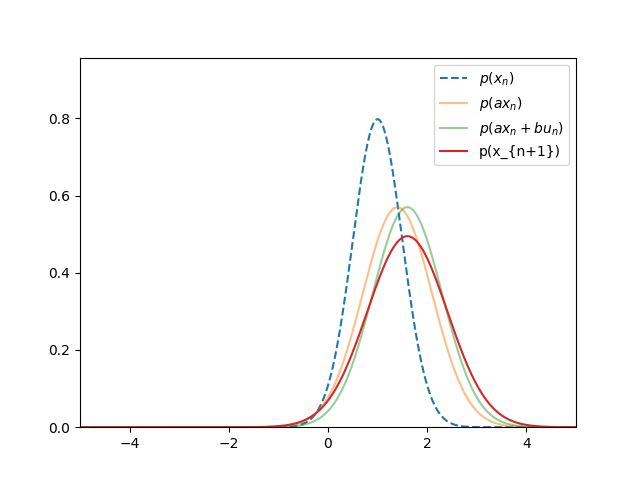

In [21]:
display(interact_manual(update01, a=w01_a, bu_n=w01_bu_n, sigma_w=w01_sigma_w));
display(fig01);

### Update
---
* Reminder: $ z_{n} = c x_n + v_n,  \,\,\, v_n \sim N(0, \sigma_v), c \in \mathcal{R}$
* Which gives:

\begin{align}
&& \mu_{n+1 \vert n+1} &= \mu_{n+1 \vert n} + \frac{\sigma_{n+1 \vert n}^2 c}{\sigma_v^2 + c^2 \sigma_{n+1 \vert n}^2}\left(z_{n+1} - c \mu_{n+1 \vert n} \right) \\
&& \sigma_{n+1 \vert n+1}^2 &= \sigma_{n+1 \vert n}^2 - \frac{\sigma_{n+1 \vert n}^4 c^2}{\sigma_v^2 + c^2 \sigma_{n+1 \vert n}^2}
\end{align}

Note: The above formulas are only valid for the specific case discussed.

In [18]:
%%capture
def kf_1d_update(mu_np1_n, sigma_np1_n, z_np1, c, sigma_v):
    mu_np1_np1 = mu_np1_n + ((sigma_np1_n**2 * c) / (sigma_v**2 + c**2 * sigma_np1_n**2)) * (z_np1 - c*mu_np1_n)
    sigma_np1_np1 = np.sqrt(sigma_np1_n**2 - ((sigma_np1_n**4 * c**2) / (sigma_v**2 + c**2 * sigma_np1_n**2)))
    
    return mu_np1_np1, sigma_np1_np1
    

mu_np1_n = 1.0
sigma_np1_n = 1.0

# parameters to be animated
z_np1 = 1.5
c = 1.0
sigma_v = 0.8


mu_np1_np1, sigma_np1_np1 = kf_1d_update(mu_np1_n, sigma_np1_n, z_np1, c, sigma_v)


xx = np.linspace(-5,5,1000)
yy_np1_n = normal_pdf(xx, mu_np1_n, sigma_np1_n)
yy_np1_np1 = normal_pdf(xx, mu_np1_np1, sigma_np1_np1)
yy_only_z = normal_pdf(xx, z_np1/c, sigma_v/c)


fig02 = plt.figure();
ax02 = fig02.add_subplot(1,1,1);
line02_np1_n,   = ax02.plot(xx, yy_np1_n, '--', label=r"$p(x_{n+1 \vert n})$");
line02_np1_np1, = ax02.plot(xx, yy_np1_np1, '-', label=r"$p(x_{n+1 \vert n+1})$");
line02_only_z,  = ax02.plot(xx, yy_only_z, '-', label="only measurement")

ax02.set_xlim(-5,5)
ax02.set_ylim(0.0, 1.2*max(np.amax(yy_np1_n), np.amax(yy_np1_np1)))
ax02.legend()

def update02(z_np1, c, sigma_v):
    global xx, ax02, yy_np1_np1, yy_np1_n, yy_only_z, mu_np1_n, sigma_np1_n
    
    mu_np1_np1, sigma_np1_np1 = kf_1d_update(mu_np1_n, sigma_np1_n, z_np1, c, sigma_v)
    
    yy_np1_np1 = normal_pdf(xx, mu_np1_np1, sigma_np1_np1)
    yy_only_z  = normal_pdf(xx, z_np1/c, sigma_v/c)
    
    line02_np1_np1.set_ydata(yy_np1_np1)
    line02_only_z.set_ydata(yy_only_z)
    
    ax02.set_ylim(0.0, 1.2*max(np.amax(yy_np1_n), np.amax(yy_np1_np1)))

    
    fig02.canvas.draw()

w02_znp1 = widgets.FloatSlider(value=z_np1, min=-1.5, max=2.5, step = 0.1)
w02_c = widgets.FloatSlider(value=c, min=0.1, max=2.0, step = 0.1)
w02_sigma_v = widgets.FloatSlider(value=sigma_v, min=0.01, max=2.0, step=0.01)

interactive(children=(FloatSlider(value=1.5, description='z_np1', max=2.5, min=-1.5), FloatSlider(value=1.0, description='c', max=2.0, min=0.1), FloatSlider(value=0.8, description='sigma_v', max=2.0, min=0.01, step=0.01), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.update02>

<IPython.core.display.Javascript object>


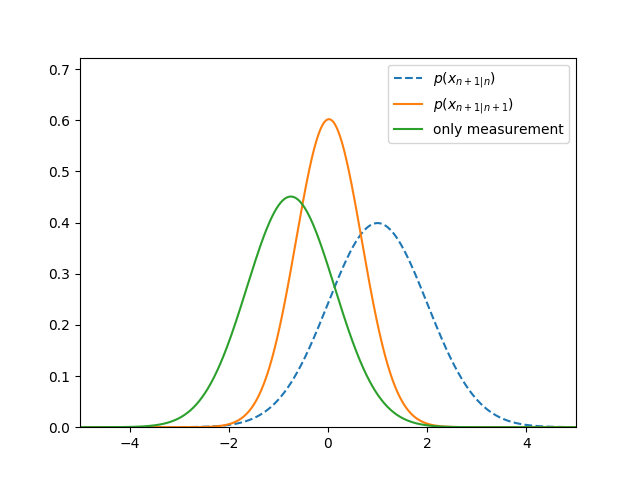

In [19]:
display(interact_manual(update02, z_np1=w02_znp1, c=w02_c, sigma_v=w02_sigma_v));
display(fig02);